# Navigation

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment and import dependencies

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python
import random
import torch
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
from dqn_agent import Agent
from unityagents import UnityEnvironment
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below.  Please run the next code cell without making any changes.

In [11]:
# please do not modify the line below
env = UnityEnvironment(file_name="/data/Banana_Linux_NoVis/Banana.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [ 1.          0.          0.          0.          0.84408134  0.          0.
  1.          0.          0.0748472   0.          1.          0.          0.
  0.25755     1.          0.          0.          0.          0.74177343
  0.          1.          0.          0.          0.25854847  0.          0.
  1.          0.          0.09355672  0.          1.          0.          0.
  0.31969345  0.          0.        ]
States have length: 37


### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine! 

In [5]:
def dqn(agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999, train=True, checkpoint_path = 'checkpoint_p1.pth'):
    """Deep Q-Learning.
    
    Args
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
        train (bool): flag deciding if the agent will train or just play through the episode
    """
    scores = []                        # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    eps = eps_start                    # initialize epsilon
    window_avgs = []
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train)[brain_name]
        state = env_info.vector_observations[0]
        score = 0
        for t in range(max_t):
            action = agent.act(state, eps if train else 0.0)
            env_info = env.step(action)[brain_name]
            next_state = env_info.vector_observations[0]   # get the next state
            reward = env_info.rewards[0]                   # get the reward
            done = env_info.local_done[0]                  # see if episode has finished
            if train:
                agent.step(state, action, reward, next_state, done)
            score += reward                                # update the score
            state = next_state                             # roll over the state to next time step
            if done:                                       # exit loop if episode finished
                break
        scores_window.append(score)       # save most recent score
        scores.append(score)              # save most recent score
        window_avg = np.mean(scores_window) # calculate average from score window
        window_avgs.append(window_avg)
        eps = max(eps_end, eps_decay*eps) # decrease epsilon
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)), end="")
        if i_episode % 100 == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_window)))
        if window_avg>=13.0 and train:
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode-100, np.mean(scores_window)))
            torch.save(agent.qnetwork_local.state_dict(), checkpoint_path)
            break
    return scores, window_avgs

### 5.Experiments

Each of the following cells will run an experiment where the in-line defined model is passed on to the agent as a parameter. 

Each new model is defined in its own class

After each experiment, performance will be visualized in plot and env is reset. The window average is also added to the dqn function, to make it easier to see the progress from the plot.

In [6]:
# Plot scores and moving average
def visualize(model, scores, window_avg):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plt.plot(np.arange(len(scores)), scores, label=model.__name__)
    plt.plot(np.arange(len(scores)), window_avgs, c='r', label='window average')
    plt.ylabel('Score')
    plt.xlabel('Episode #')
    plt.legend(loc='lower right')
    plt.show()


In [7]:
# Naive DQN with optional naive dueling 
class NaiveDQN(nn.Module):
    def __init__(self, state_size, action_size, seed, is_dueling = False):
        super(NaiveDQN, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.is_dueling = is_dueling
        self.fc1 = nn.Linear(state_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_size)
        
        # state value to calculate advantage later for dueling network
        self.state_value = nn.Linear(64, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        if self.is_dueling:
            # Q = advantage + state value
            return self.fc3(x) + self.state_value(x)
        return self.fc3(x)

Episode 100	Average Score: 0.19
Episode 200	Average Score: 0.93
Episode 300	Average Score: 1.44
Episode 400	Average Score: 2.35
Episode 500	Average Score: 3.55
Episode 600	Average Score: 4.53
Episode 700	Average Score: 5.42
Episode 800	Average Score: 6.37
Episode 900	Average Score: 6.95
Episode 1000	Average Score: 7.60


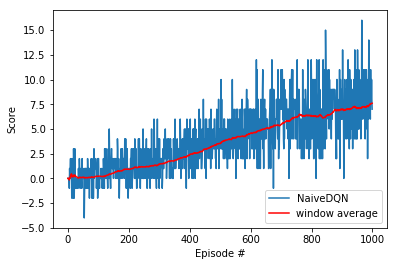

{'BananaBrain': <unityagents.brain.BrainInfo at 0x7fca104e4710>}

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, model=NaiveDQN, is_dueling=False)
scores, window_avgs = dqn(agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999, train=True, checkpoint_path = 'checkpoint_NaiveDQN_no_dueling.pth')
visualize(NaiveDQN, scores, window_avgs)
env.reset()

Now we try using same NaiveDQN with dueling turned on

Episode 100	Average Score: -0.08
Episode 200	Average Score: 0.791
Episode 300	Average Score: 1.36
Episode 400	Average Score: 2.21
Episode 500	Average Score: 2.87
Episode 600	Average Score: 3.98
Episode 700	Average Score: 4.98
Episode 800	Average Score: 6.20
Episode 900	Average Score: 7.00
Episode 1000	Average Score: 8.43


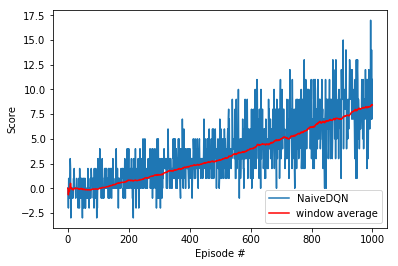

{'BananaBrain': <unityagents.brain.BrainInfo at 0x7fca1105cb38>}

In [10]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, model=NaiveDQN, is_dueling=True)
scores, window_avgs = dqn(agent, n_episodes=1000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999, train=True, checkpoint_path = 'checkpoint_NaiveDQN_dueling.pth')
visualize(NaiveDQN, scores, window_avgs)
env.reset()

Result seems slightly better than non-dueling, since non-dueling seems to stop making progress after episode 800.
Since dueling does not seem to reach a saturating point yet, let's try running it with 2000 episodes to see how far it can go.

Episode 100	Average Score: 0.16
Episode 200	Average Score: 0.66
Episode 300	Average Score: 1.14
Episode 400	Average Score: 2.38
Episode 500	Average Score: 2.88
Episode 600	Average Score: 4.61
Episode 700	Average Score: 5.21
Episode 800	Average Score: 5.85
Episode 900	Average Score: 6.99
Episode 1000	Average Score: 7.66
Episode 1100	Average Score: 8.04
Episode 1200	Average Score: 8.09
Episode 1300	Average Score: 9.27
Episode 1400	Average Score: 10.13
Episode 1500	Average Score: 10.34
Episode 1600	Average Score: 10.57
Episode 1700	Average Score: 11.51
Episode 1800	Average Score: 12.42
Episode 1900	Average Score: 12.39
Episode 2000	Average Score: 12.69


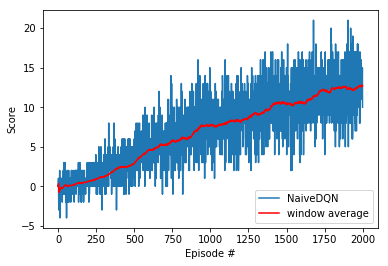

{'BananaBrain': <unityagents.brain.BrainInfo at 0x7fc9e7ba5a90>}

In [11]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, model=NaiveDQN, is_dueling=True)
scores, window_avgs = dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999, train=True, checkpoint_path = 'checkpoint_NaiveDQN_dueling.pth')
visualize(NaiveDQN, scores, window_avgs)
env.reset()

Now we see that scores keep growing at steady rate until around episode 1500 , then slightly more flattened after that.
Which means increasing episodes has started to reach its blocker.
Now let's try to add more layers and neurons to see if more complicated network can push it further.

In [9]:
# Naive DQN with deeper layers and more neurons
class NaiveDQN_v2(nn.Module):
    def __init__(self, state_size, action_size, seed, is_dueling = False):
        super(NaiveDQN_v2, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.is_dueling = is_dueling
        self.fc1 = nn.Linear(state_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, action_size)
        
        # state value to calculate advantage later for dueling network
        self.state_value = nn.Linear(64, 1)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = F.relu(self.fc5(x))
        if self.is_dueling:
            # Q = advantage + state value
            return self.fc6(x) + self.state_value(x)
        return self.fc6(x)

Episode 100	Average Score: -0.06
Episode 200	Average Score: 0.521
Episode 300	Average Score: 1.27
Episode 400	Average Score: 2.35
Episode 500	Average Score: 3.56
Episode 600	Average Score: 4.37
Episode 700	Average Score: 4.70
Episode 800	Average Score: 5.85
Episode 900	Average Score: 6.78
Episode 1000	Average Score: 7.41
Episode 1100	Average Score: 8.36
Episode 1200	Average Score: 7.78
Episode 1300	Average Score: 9.62
Episode 1400	Average Score: 9.70
Episode 1500	Average Score: 10.22
Episode 1600	Average Score: 10.89
Episode 1700	Average Score: 10.93
Episode 1800	Average Score: 11.31
Episode 1900	Average Score: 12.18
Episode 2000	Average Score: 12.51


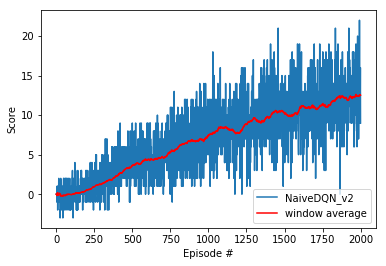

{'BananaBrain': <unityagents.brain.BrainInfo at 0x7f7a740a90b8>}

In [12]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, model=NaiveDQN_v2, is_dueling=True)
scores, window_avgs = dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.999, train=True, checkpoint_path = 'checkpoint_NaiveDQN_v2_dueling.pth')
visualize(NaiveDQN_v2, scores, window_avgs)
env.reset()

Looks like more complex network does not help much. The performance is even slightly worse compared to simpler network.

Now let's look at the other parameters and see if tweaking them might improve the result. Starting with epsilon.

Intuitively, highly complex network increase the likelihood to overfit ("highly exploitative" characteristic), and since we already keep epsilon value and epsilon decay rate at the highest possible value, it means we encourage it to be as "explorative" as possible. 

This seems to be a nice counter to the "exploitative" tendency of the neural network. However, since it's the max settings available, we don't know if it makes the agent explores too much, therefore neglect the benefits provided by the deep Q-learning policy.

There is also a chance that it already made a nice balance, which means decreasing epsilon further might push the agent to the even more "exploitative" side, therefore decrease the performance further. Let's run an experiment to verify this anyway. If the former is true then good, we did make some progress. Otherwise if the latter is true, I will rollback to the simpler network with lower epsilon (meaning more exploration tendency comes from the network and more exploitative tendency comes from epsilon, to still keep the balance).

The experiment below will run with same setup as the previous one, except that esp_decay will be smaller, at 0.8, meaning the agent will change from explorative to exploitative mode more quickly.

Episode 100	Average Score: 3.25
Episode 200	Average Score: 7.31
Episode 300	Average Score: 10.61
Episode 400	Average Score: 12.65
Episode 413	Average Score: 13.05
Environment solved in 313 episodes!	Average Score: 13.05


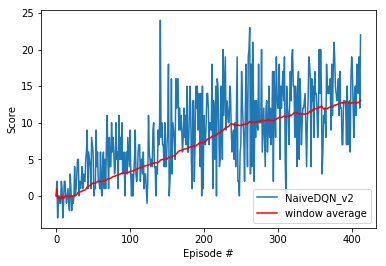

{'BananaBrain': <unityagents.brain.BrainInfo at 0x7fd59a0b0208>}

In [10]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, model=NaiveDQN_v2, is_dueling=True)
scores, window_avgs = dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.8, train=True, checkpoint_path = 'checkpoint_NaiveDQN_v2_dueling.pth')
visualize(NaiveDQN_v2, scores, window_avgs)
env.reset()

This looks awesome! So by reducing epsilon decay rate by 20%, we increased the performance 5 times, exactly the inverse proportion ! Looks like the default setting at 0.99 is too high and therefore the agent was acting too randomly, and the deep Q-network actually did a pretty good job at figuring out the optimal policy, so all we have to do is to follow it.

Now I'm even more curious to see what happens if we follow the network even more strictly. Let's try one more with epsilon decay reduced even further, at 0.5

Episode 100	Average Score: 4.08
Episode 200	Average Score: 8.89
Episode 300	Average Score: 12.66
Episode 315	Average Score: 13.02
Environment solved in 215 episodes!	Average Score: 13.02


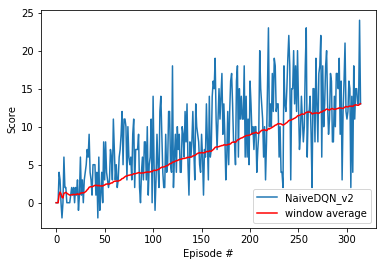

{'BananaBrain': <unityagents.brain.BrainInfo at 0x7fd5985fce10>}

In [11]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, model=NaiveDQN_v2, is_dueling=True)
scores, window_avgs = dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.5, train=True, checkpoint_path = 'checkpoint_NaiveDQN_v2_dueling.pth')
visualize(NaiveDQN_v2, scores, window_avgs)
env.reset()

That looks even better. Now let's try another optimization. Current dueling network has pretty simple config for value stream, without any intermediate layer. What if we split the 2 streams earlier to allow more layers in the value stream ? This might lead to a more accurate state stream. Also let's try to address the identifiability problem when combining 2 streams together (more explaination in below comments).

In [8]:
# DQN with improved dueling
class DQN_dueling_improved(nn.Module):
    def __init__(self, state_size, action_size, seed, is_dueling = False):
        super(DQN_dueling_improved, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.is_dueling = is_dueling
        self.fc1 = nn.Linear(state_size, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        
        # Advantage stream
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, action_size)
        
        # Value stream
        self.fc7 = nn.Linear(128, 64)
        self.fc8 = nn.Linear(64, 1)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        
        advantages = self.fc6(F.relu(self.fc5(x)))
        
        # Without considering state value, Q value has the same meaning as advantages
        # (how advantageous each action brings when taken at the current state)
        if self.is_dueling is not True:
            return advantages
        
        state_value = self.fc8(F.relu(self.fc7(x)))
        
        # According to https://arxiv.org/abs/1511.06581, naively summing up state value and advantages
        # might lead to an unidentifiability problem where given Q we can't identify from which V and A
        # it came from uniquely. By taking into account the mean of advantages, we make the network more stable
        # since each update only needs to compensate a smaller amount (minus advantages.mean) instead of
        # whole change caused by optimal action.
        return state_value + advantages - advantages.mean()

Episode 100	Average Score: 3.58
Episode 200	Average Score: 7.87
Episode 300	Average Score: 9.511
Episode 400	Average Score: 12.55
Episode 409	Average Score: 13.00
Environment solved in 309 episodes!	Average Score: 13.00


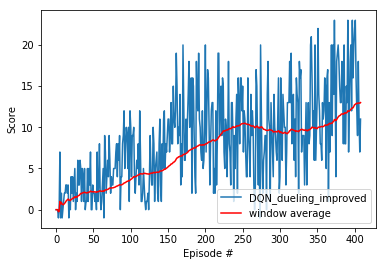

{'BananaBrain': <unityagents.brain.BrainInfo at 0x7f7982748f60>}

In [9]:
agent = Agent(state_size=state_size, action_size=action_size, seed=0, model=DQN_dueling_improved, is_dueling=True)
scores, window_avgs = dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.5, train=True, checkpoint_path = 'checkpoint_DQN_dueling_improved.pth')
visualize(DQN_dueling_improved, scores, window_avgs)
env.reset()

This does not seem to make a big difference, due to the 250-300 episodes where the agent seems to struggle. But at least the performance is still good enough. Now let's try one final optimization, where we implement prioritized experience replay into the agent and turn it on via a flag.

Episode 100	Average Score: 6.31
Episode 200	Average Score: 9.08
Episode 300	Average Score: 12.39
Episode 321	Average Score: 13.00
Environment solved in 221 episodes!	Average Score: 13.00


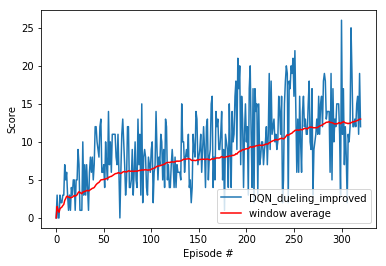

{'BananaBrain': <unityagents.brain.BrainInfo at 0x7f04f3514198>}

In [12]:
# Finally try with prioritized experience replay
agent = Agent(state_size=state_size, action_size=action_size, seed=0, model=DQN_dueling_improved, is_dueling=True, is_prioritized = True)
scores, window_avgs = dqn(agent, n_episodes=2000, max_t=1000, eps_start=1.0, eps_end=0.01, eps_decay=0.5, train=True, checkpoint_path = 'checkpoint_DQN_dueling_prioritized.pth')
visualize(DQN_dueling_improved, scores, window_avgs)
env.reset()

### End of experiments. Closing the environment

In [12]:
env.close()

#### Conclusion and future work

Throughout these experiments we have witnessed the agent evolved from a naive DQN bot with simple neural network setup to a more performant one thanks to more complex network config, builtin prioritized experience replay and especially epsilon value tweak.

The biggest lesson I can see here is, exploration is good but we should also try to avoid too much randomness.

For future, I would try to explore Double DQN, Noisy DQN. There is also some nice little improvement called Reward-Based Epsilon Decay https://arxiv.org/abs/1910.13701 which might be useful. More complex neural network setup such as convolutional network is also a candidate. And of course once we have all those available, combining all to make a Rainbow DQN is definitely something to try out.